In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
from pprint import pprint
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [2]:
### Rank sectors by their 1st loan propensity

In [3]:
sorig = pd.read_csv('loan_1st_by_sic_new.csv', dtype={'CompanyNumber': str, 'Sics': str}, index_col=0)

print(sorig.shape)
sorig.head(2)

C:\Users\liamk\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(4319749, 7)


,CompanyName,CompanyNumber,RegAddress.Country,RegAddress.Region,Sics,Tenure,Event
0,ODHAMS PRESS LIMITED,01470445,ENGLAND,LONDON,99999,13979,1
1,M SEALS UK LIMITED,01470514,ENGLAND,LONDON,46900,3491,1


In [15]:
dfsic = pd.read_csv('SIC07.csv', header=0, dtype=str)

print(dfsic.shape)
dfsic.head(2)

(731, 2)


,SIC Code,Description
0,01110,"Growing of cereals (except rice), leguminous c..."
1,01120,Growing of rice


In [5]:
# London data to start
ledit = sorig.copy()

ledit = ledit[ledit['RegAddress.Region'] == 'LONDON']

ledit.shape

(1183685, 7)

## SA Test

In [6]:
kmf = KaplanMeierFitter()

inf


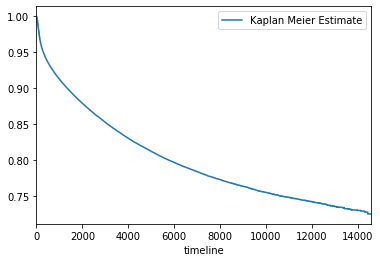

In [8]:
kmf.fit(ledit.Tenure, ledit.Event, label='Kaplan Meier Estimate')
print(kmf.median_survival_time_)
kmf.plot(ci_show=False)

In [10]:
T = ledit.Tenure
E = ledit.Event
groups = ledit.Sics
type(groups)
chemists = (groups.str.contains('47730'))
dentists = (groups.str.contains('86230'))

Dentist median SA: 8390.0
Chemist median SA: 2480.0


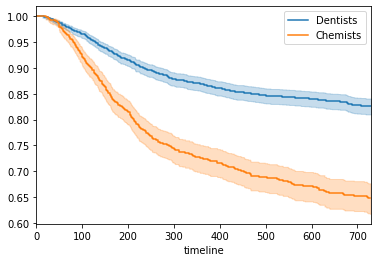

In [12]:
kmf1 = KaplanMeierFitter()

## fit the model for 1st cohort
kmf1.fit(T[dentists], E[dentists], label='Dentists')
print(f'Dentist median SA: {kmf1.median_survival_time_}')
a1 = kmf1.plot(loc=slice(0, 730))

## fit the model for 2nd cohort
kmf1.fit(T[chemists], E[chemists], label='Chemists')
print(f'Chemist median SA: {kmf1.median_survival_time_}')
kmf1.plot(ax=a1, loc=slice(0, 730))

## Iterated Thru Sectors

In [77]:
T = ledit.Tenure
E = ledit.Event
groups = ledit.Sics

dfrank = pd.DataFrame(columns=['Code', 'Desc', 'MedDays', 'Num'], index=range(len(dfsic)))

for index, row in dfsic.iterrows():
    group = (groups.str.contains(row.loc['SIC Code']))
    kmf = KaplanMeierFitter()
    kmf.fit(T[group], E[group])
    
    dfrank.loc[index].Code = row.loc['SIC Code']
    dfrank.loc[index].Desc = row.loc['Description']
    dfrank.loc[index].MedDays = kmf.median_survival_time_
    dfrank.loc[index].Num = group.sum()

print(dfrank.shape)
dfrank.head(2)

(731, 4)


,Code,Desc,MedDays,Num
0,01110,"Growing of cereals (except rice), leguminous c...",inf,151
1,01120,Growing of rice,inf,33


In [79]:
dfyes = dfrank.copy()

dfyes.MedDays.replace(np.inf, np.nan, inplace=True)
dfyes.dropna(inplace=True)

dfyes = dfyes.astype({'MedDays': 'int32'})
dfyes['MedYears'] = round(dfyes.MedDays/ 365, 2)

dfyes = dfyes[['Code', 'Desc', 'MedDays', 'MedYears', 'Num']]

dfyes.sort_values(by='MedDays', inplace=True)

print(dfyes.shape)
dfyes.head(5)

(155, 5)


,Code,Desc,MedDays,MedYears,Num
51,08920,Extraction of peat,83,0.23,2
562,65201,Life reinsurance,119,0.33,676
563,65202,Non-life reinsurance,121,0.33,1454
271,28922,Manufacture of earthmoving equipment,135,0.37,4
560,65110,Life insurance,142,0.39,1039


In [80]:
# dfyes.to_csv('London_Sic_Median_SA.csv')

## Further Test

In [83]:
sorig['RegAddress.Country'].value_counts()[:5]

ENGLAND             3904235
SCOTLAND             223433
WALES                121546
NORTHERN IRELAND      62490
UNITED KINGDOM         7853
Name: RegAddress.Country, dtype: int64

In [84]:
sorig['RegAddress.Region'].value_counts()

LONDON                      1183685
SOUTH EAST                   628748
NORTH WEST                   435997
EAST OF ENGLAND              406509
WEST MIDLANDS                338416
SOUTH WEST                   304835
YORKSHIRE AND THE HUMBER     260369
EAST MIDLANDS                244561
NORTH EAST                    95505
Name: RegAddress.Region, dtype: int64

(4240, 7)


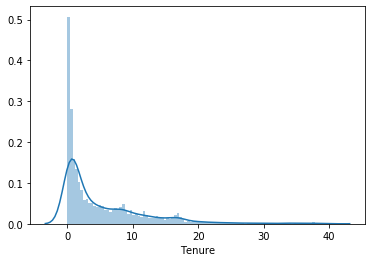

In [103]:
chem1 = sorig[sorig.Sics.str.contains('47730')]
print(chem1.shape)
sns.distplot(chem1.Tenure/ 365, bins=100)

(4207, 7)


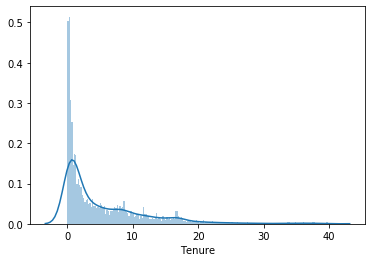

In [104]:
chem2 = sorig[sorig.Sics.str.contains('47730')]
chem2 = chem2[~chem2.Sics.str.contains('68100|68201|68202|68209|68310|68320|41100|41201|41202')]
print(chem2.shape)
sns.distplot(chem2.Tenure/ 365, bins=200)

(31702, 7)


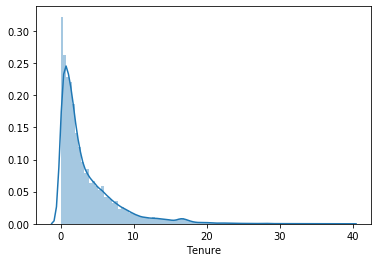

In [106]:
bar1 = sorig[sorig.Sics.str.contains('56302')]
print(bar1.shape)
sns.distplot(bar1.Tenure/ 365, bins=100)

(31472, 7)


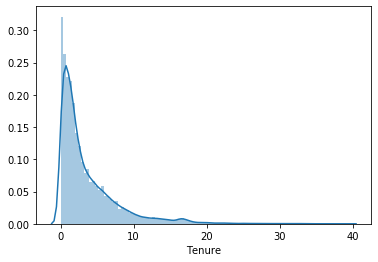

In [107]:
bar2 = sorig[sorig.Sics.str.contains('56302')]
bar2 = bar2[~bar2.Sics.str.contains('68100|68201|68202|68209|68310|68320|41100|41201|41202')]
print(bar2.shape)
sns.distplot(bar2.Tenure/ 365, bins=100)